In [1]:
import sys
sys.path.append('/opt/code/face/dual_shot')
import numpy as np
import keras.layers as KL
from keras import Model
from dual_conf import current_config as conf
from net.dual_shot import test_net
from prepare_data.generator import gen_test,layer_strides,map_size,e_scale,ratio
import os
from prepare_data.model_target import apply_regress,init_anchors

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
weight_path = os.path.join(conf.output_dir, 'weights.h5')
print('loading trained model from:',weight_path)

Using TensorFlow backend.
/root/anaconda3/envs/keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/root/anaconda3/envs/keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


using: resnet50 as the base model
loading trained model from: /opt/code/face/dual_shot/train_out/weights.h5


## load model 

In [2]:
net_in = KL.Input([640, 640, 3], name='image_array')
ss_cls, ss_regr = test_net(net_in)
model = Model(inputs=[net_in], outputs=[ss_cls, ss_regr])
model.summary()
model.load_weights(weight_path, by_name=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_array (InputLayer)        (None, 640, 640, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 646, 646, 3)  0           image_array[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 320, 320, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, 320, 320, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## load data

In [3]:
gen = gen_test(conf.batch_size, 'train')
x_val,y_val = next(gen)
print(x_val.shape,y_val)

Error bbox number to filter : 48,  bbox number: 159376
(4, 640, 640, 3) [array([[563.04191011, 267.16237249, 580.04637589, 287.00091591],
       [526.82869594, 290.77968608, 541.62887912, 307.78415186],
       [476.75999114, 271.88583521, 492.81976438, 292.03927614],
       [447.15962478, 294.55845625, 461.01511541, 309.98843446],
       [415.66987333, 270.31134764, 431.09985154, 290.46478856],
       [334.42631459, 285.11153082, 352.37547291, 308.09904938],
       [375.04809396, 273.46032278, 391.73766223, 293.92866122],
       [391.1078672 , 258.97503712, 393.94194483, 262.43890978],
       [403.07397275, 262.43890978, 404.96335783, 265.58788492]])
 array([[180.73089701,   0.        , 270.03322259, 119.73807297]])
 array([[ 34.43849766, 388.52111805,  94.79719617, 453.52279337],
       [144.70919687, 378.07442023, 207.38938379, 453.52279337],
       [212.0323606 , 338.60911735, 268.90882651, 401.28930427],
       [358.28613009, 357.18102458, 409.35887499, 419.86121151],
       [361.7

## make prediction

In [4]:
ss_cls,ss_regr= model.predict(x_val)
print(ss_cls.shape,ss_regr.shape)

(4, 34125, 2) (4, 34125, 4)


In [5]:
ss_cls = np.exp(ss_cls) / np.sum(np.exp(ss_cls), axis=0)
ss_cls.shape

(4, 34125, 2)

In [6]:
# ss_cls = np.random.rand(4,conf.num_anchor,2)
# ss_regr = np.random.rand(4,conf.num_anchor,4)
# print(ss_cls.shape,ss_regr.shape)

## init anchors

In [7]:
e_anchors = init_anchors(layer_strides, map_size, ratio, e_scale)
e_anchors.shape

(34125, 4)

## apply delta 

In [8]:
pred_box = np.empty_like(ss_regr)
for i in range(len(ss_regr)):
    pred_box[i] = apply_regress(ss_regr[i],e_anchors)

## top 5k

In [9]:
pred_score = ss_cls[...,1]

In [10]:
sort_inds = np.argsort(pred_score)

In [11]:
pred_score = pred_score[np.arange(pred_score.shape[0])[:,None], sort_inds]
pred_box = pred_box[np.arange(pred_box.shape[0])[:,None], sort_inds]

In [12]:
pred_score =pred_score[:,:5000]
pred_box =pred_box[:,:5000]
print(pred_score.shape,pred_box.shape)

(4, 5000) (4, 5000, 4)


In [13]:
pred_score

array([[2.85599936e-06, 3.00473289e-06, 3.44855221e-06, ...,
        1.10179417e-01, 1.10205203e-01, 1.10244989e-01],
       [1.50232008e-05, 1.80782208e-05, 1.99119659e-05, ...,
        3.65655944e-02, 3.65702398e-02, 3.65717076e-02],
       [6.96792122e-05, 1.29799635e-04, 1.95793880e-04, ...,
        1.12025514e-01, 1.12045452e-01, 1.12069950e-01],
       [1.99340720e-05, 2.79399337e-05, 4.47239509e-05, ...,
        2.40987074e-02, 2.40989570e-02, 2.41000447e-02]], dtype=float32)

## nms

In [14]:

def bbox_vote(det):
    order = det[:, 4].ravel().argsort()[::-1]
    det = det[order, :]
    while det.shape[0] > 0:
        # IOU
        area = (det[:, 2] - det[:, 0] + 1) * (det[:, 3] - det[:, 1] + 1)
        xx1 = np.maximum(det[0, 0], det[:, 0])
        yy1 = np.maximum(det[0, 1], det[:, 1])
        xx2 = np.minimum(det[0, 2], det[:, 2])
        yy2 = np.minimum(det[0, 3], det[:, 3])
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        o = inter / (area[0] + area[:] - inter)
        # get needed merge det and delete these det
        merge_index = np.where(o >= 0.3)[0]
        det_accu = det[merge_index, :]
        det = np.delete(det, merge_index, 0)
        if merge_index.shape[0] <= 1:
            continue
        det_accu[:, 0:4] = det_accu[:, 0:4] * np.tile(det_accu[:, -1:], (1, 4))
        max_score = np.max(det_accu[:, 4])
        det_accu_sum = np.zeros((1, 5))
        det_accu_sum[:, 0:4] = np.sum(det_accu[:, 0:4], axis=0) / np.sum(det_accu[:, -1:])
        det_accu_sum[:, 4] = max_score
        try:
            dets = np.row_stack((dets, det_accu_sum))
        except:
            dets = det_accu_sum
    dets = dets[0:750, :]
    return dets

In [15]:
#for i in range(len(pred_score)):
for i in range(1):
    det = np.concatenate([pred_box[i],np.expand_dims(pred_score[i],1)],axis=1)
    final_box = bbox_vote(det)

In [16]:
final_box

array([[3.00784241e+02, 3.71068153e+01, 3.41138214e+02, 7.46549759e+01,
        1.10244989e-01],
       [5.64985413e+02, 5.03831390e+02, 6.03650879e+02, 5.39160461e+02,
        1.10205203e-01],
       [5.50401123e+02, 3.15857422e+02, 5.71818970e+02, 3.27984406e+02,
        1.10179417e-01],
       ...,
       [3.85659027e+02, 6.24048706e+02, 4.12860840e+02, 6.35499939e+02,
        4.26257700e-02],
       [1.47321381e+02, 6.24185730e+02, 1.75895309e+02, 6.34908875e+02,
        4.22099233e-02],
       [2.16003754e+02, 5.76484924e+02, 2.31761459e+02, 5.89071594e+02,
        4.17942628e-02]])

In [17]:
final_box.shape

(750, 5)

## visualize

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plot_anchor(img_array, anchor_list):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img_array.astype(int))
    for a in anchor_list:
        y1,x1,y2,x2 = [int(i) for i in a]
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


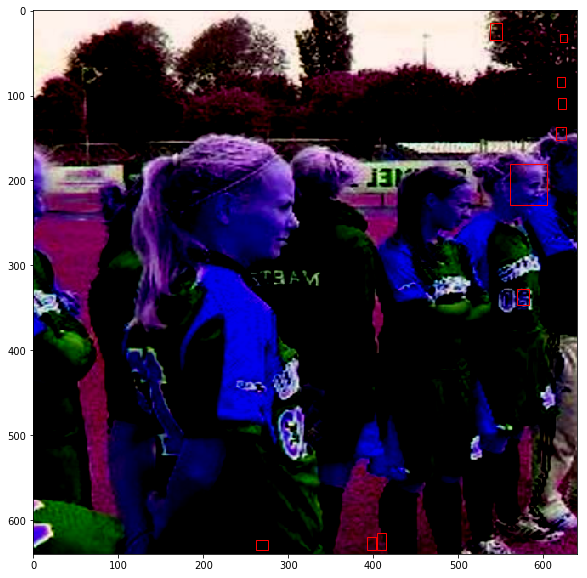

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


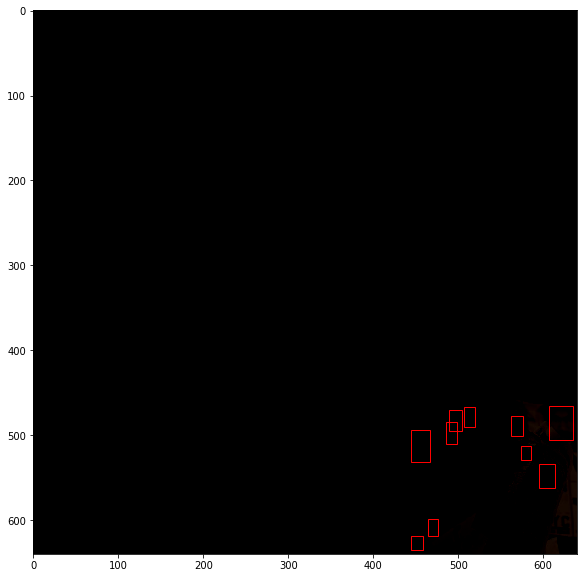

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


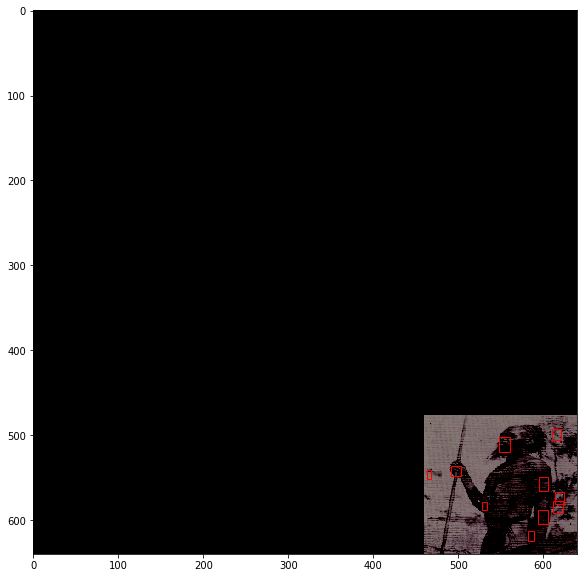

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


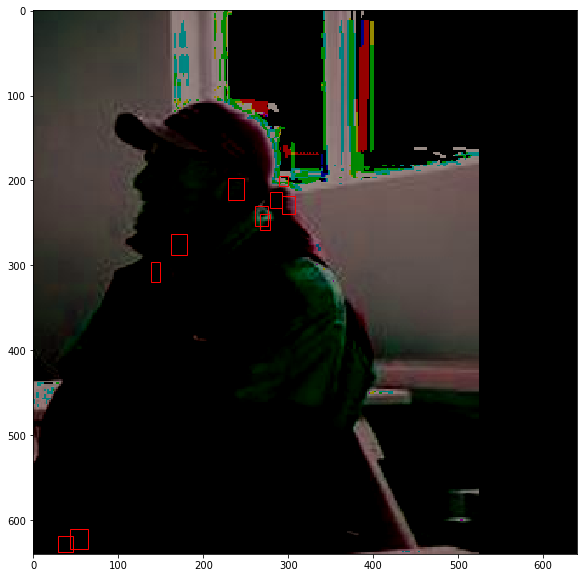

In [7]:
img_array = x_val[0]
anchor_list = final_box[:10,:4]
plot_anchor(img_array, anchor_list)